# Previsão de vazão de rios

Utilizam-se os dados de furnas e de camargos.

Importam-se as seguintes bibliotecas externas:

 - pandas
 - matplotlib
 - statsmodels
 - sklearn
 - seaborn
 - numpy
 - keras
 - theano
 - pmdarima >= 1.3.0
 
A aplicação jupyternotify é usada para notificar o fim da execução do código

In [1]:
%load_ext jupyternotify
%autonotify -a 10

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import pickle

import os
os.environ['KERAS_BACKEND'] = 'theano'
#export THEANO_FLAGS=blas.ldflags="-L${MKLROOT}/lib/intel64 -lmkl_rt -lpthread -lm -ldl"
#os.environ['THEANO_FLAGS'] = blas.ldflags="-L/usr/lib64/atlas/ -lptf77blas -lptcblas -latlas"' #'blas.ldflags="-L/usr/lib64/ -lblas"'#'blas.ldflags="-L/usr/lib64/ -lf77blas -latlas -lgfortran"' #"-L/usr/local/lib/ -lblas"'

from keras.models import Sequential, load_model, Model
from keras import regularizers
from keras.layers import Concatenate, Permute, Dot, Input, LSTM, Multiply, RepeatVector, Dense, Activation, Lambda
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, GaussianNoise, GaussianDropout, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid") # whitegrid
sns.set_context("notebook") # paper
if not os.path.exists('historicos_naive'):
    os.makedirs('historicos_naive')
if not os.path.exists('modelos_naive'):
    os.makedirs('modelos_naive')

Using Theano backend.


Definição de constantes:

In [3]:
janela = 12 # 2, 3, 4, 6, 8, 12
adicional_reco = 60 # 12, 24, 48, 72, 96
teste = 120
fracao_valida = 0.2

Funções auxiliadoras para o cálculo de métricas, demonstração gráficas e montagem das matrizes

In [4]:
indices_teste_seco = [k for k in range(-teste,0) if k%-12 in [-8,-7,-6,-5,-4,-3]]
indices_teste_umido = [k for k in range(-teste,0) if k%-12 in [0,-11,-10,-9,-2,-1]]

def imprime_metricas(real, predito, fator_normalizacao, teste=False):
    print('RMSE = ', np.sqrt(np.mean(np.square(predito - real)))*fator_normalizacao, end=', ')
    print('MSE = ', metrics.mean_squared_error(real, predito)*fator_normalizacao**2 , end=', ')
    print('MAPE = ', 100*np.mean(np.abs(predito-real)/real), '%', end=', ')
    print('MAE = ', metrics.mean_absolute_error(real, predito)*fator_normalizacao , end=', ')
    print('R = ', metrics.r2_score(real, predito))
    if teste:
        ps = predito[indices_teste_seco]
        rs = real[indices_teste_seco]
        pu = predito[indices_teste_umido]
        ru = real[indices_teste_umido]
        print('MAPE seco = ', 100*np.mean(np.abs(ps-rs)/rs), '%')
        print('MAPE umido = ', 100*np.mean(np.abs(pu-ru)/ru), '%')

def mostra_treinamento(historico, init=16):
    plt.plot(historico['loss'][init:])
    plt.plot(historico['val_loss'][init:])
    plt.ylabel('Erro Relativo Médio')
    plt.xlabel('Iterações')
    plt.legend(['Treinamento', 'Validação'], loc='upper right')
    plt.show()

def mostra_performance(modelo, entrada, saida, fatores_normalizacao, teste=False):
    predito = modelo.predict(entrada)
    nomes = ['Furnas', 'Camargos']
    for i in range(len(fatores_normalizacao)):
        print(nomes[i])
        plt.plot(saida[:, i], '-o')
        plt.plot(predito[:, i], '-o')
        plt.legend(['Real', 'Predito'], loc='upper right')
        if teste:
            plt.xticks([0]+[(k+1)*12-1 for k in range(10)], ['jan/03']+['dez/%02d'%(k+3) for k in range(10)])
        else:
            plt.xticks(np.arange(0, len(saida)+1, step=12))
        plt.show()
        imprime_metricas(saida[:, i], predito[:, i], fatores_normalizacao[i], teste)

def salva_historico(historico, nome_arquivo):
    arquivo = open(nome_arquivo, 'wb')
    pickle.dump(historico, arquivo)
    arquivo.close()

def carrega_historico(nome_arquivo):
    try:
        arquivo = open(nome_arquivo, 'rb')
        historico = pickle.load(arquivo)
        arquivo.close()
    except:
        return False
    return historico

def separa_series(serie1, serie2, janela, inicio_y, tam):
    x_separado = np.zeros((tam, 2*janela))
    for i in range(tam):
        x_separado[i, 0:janela] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, janela:2*janela] = serie2[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def separa_series_reco(serie1, serie2, janela, inicio_y, tam):
    x_separado = np.zeros((tam, janela, 2))
    for i in range(tam):
        x_separado[i, :, 0] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, :, 1] = serie2[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

Carregamento incial dos dados

In [5]:
furnas = np.array([float(a) for a in open('dados/furnas.csv', 'r').read().split('\n') if a])
camargos = np.array([float(a) for a in open('dados/camargos.csv', 'r').read().split('\n') if a])
assert(len(furnas) == len(camargos))
valida = int((len(furnas) - teste - janela) * fracao_valida)
treino = len(furnas) - teste - valida - janela
fatores_normalizacao = [furnas[:treino].max(), camargos[:treino].max()]
furnas /= fatores_normalizacao[0]
camargos /= fatores_normalizacao[1]

x_treina, y_treina = separa_series(furnas, camargos, janela, janela, treino)
x_valida, y_valida = separa_series(furnas, camargos, janela, janela+treino, valida)
x_teste, y_teste = separa_series(furnas, camargos, janela, janela+treino+valida, teste)

assert(x_treina[31, -1] == y_treina[30, -1])
print('Treino, ', treino)
print('Validação, ', valida)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela)

Treino,  682
Validação,  170
Teste,  120
Total,  972


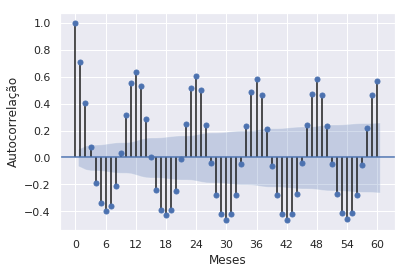

In [6]:
plot_acf(furnas, lags=60)
plt.xticks(np.arange(0, 61, step=6))
plt.title('')
plt.ylabel('Autocorrelação')
plt.xlabel('Meses')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)

# Um único neurônio (regressão linear)

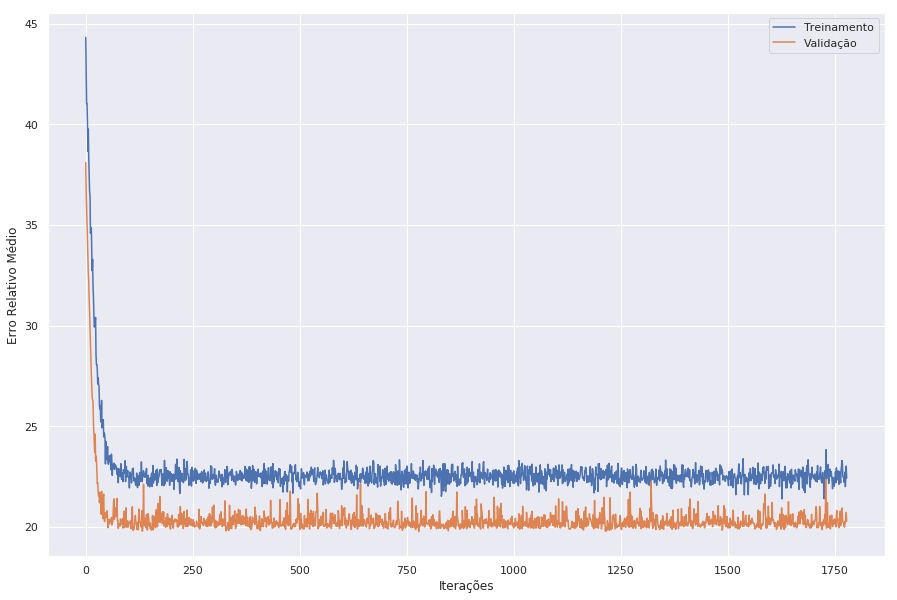

Furnas


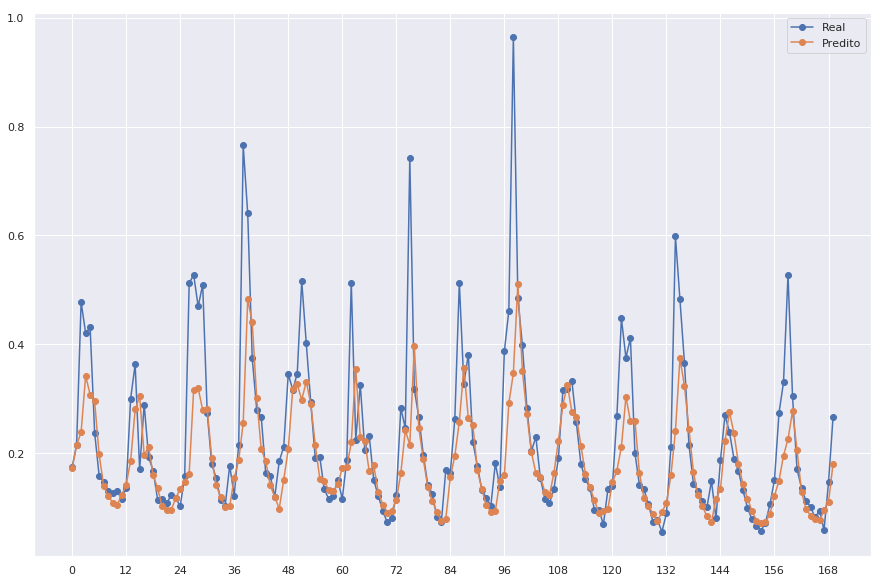

RMSE =  424.08026182241116, MSE =  179844.0684673648, MAPE =  20.839587435210362 %, MAE =  226.9167863261612, R =  0.4437221522094942
Camargos


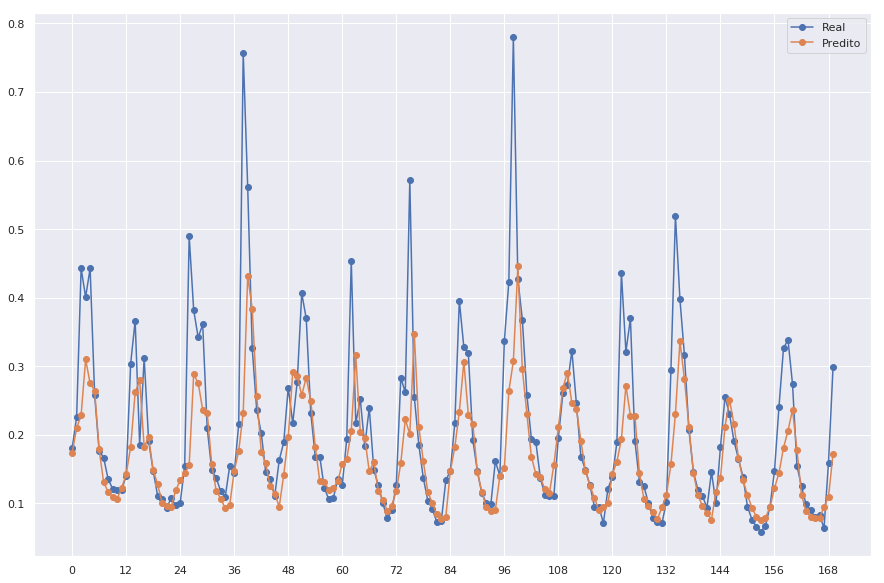

RMSE =  54.06991203900732, MSE =  2923.5553879059885, MAPE =  18.678904172797616 %, MAE =  29.00712028671713, R =  0.4527097901492467


In [7]:
def modelo_uno(janela, quant_rios, ruido=0.05):
    entrada = Input(shape=(janela * quant_rios,))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    estimativa = Dense(quant_rios, activation='tanh')(entrada_ruidosa)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive/melhor_uno.h5'): # or True:
    uno = modelo_uno(janela, 2)
    uno.compile(optimizer='adam', loss='mape')
    parar_uno = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, min_delta=0)
    salvar_uno = ModelCheckpoint('modelos_naive/melhor_uno.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_uno = uno.fit(x_treina, y_treina, epochs=10000, validation_data=(x_valida, y_valida), verbose=0, callbacks=[parar_uno, salvar_uno])
    salva_historico(historico_uno.history, 'historicos_naive/uno')

mostra_treinamento(carrega_historico('historicos_naive/uno'))
uno = load_model('modelos_naive/melhor_uno.h5')
mostra_performance(uno, x_valida, y_valida, fatores_normalizacao)

# Multilayer perceptron

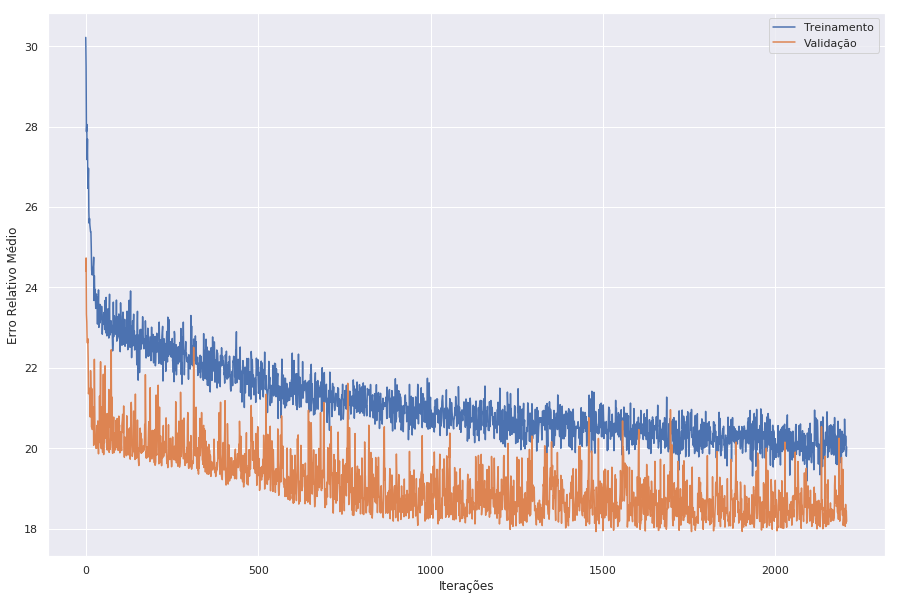

Furnas


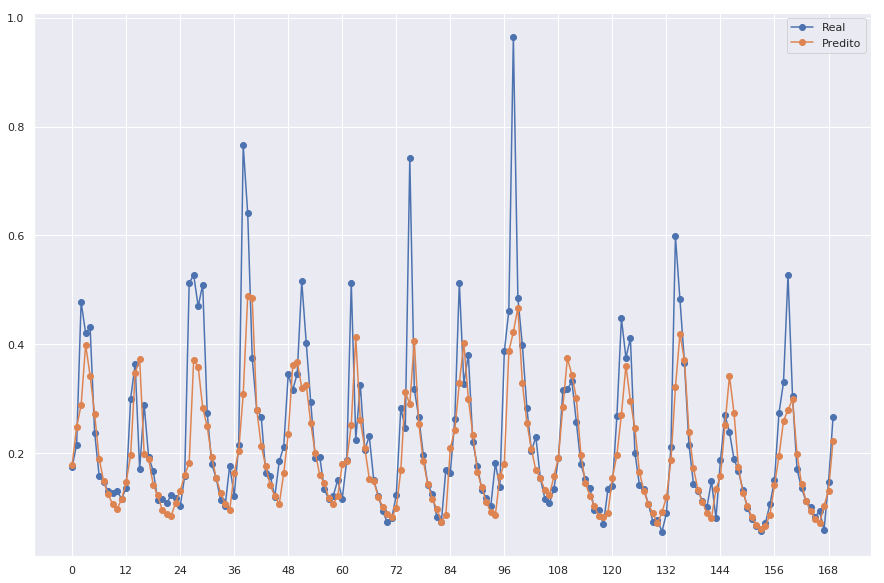

RMSE =  371.016457909797, MSE =  137653.2120399322, MAPE =  19.032362534157517 %, MAE =  199.04128001840672, R =  0.5742231968639047
Camargos


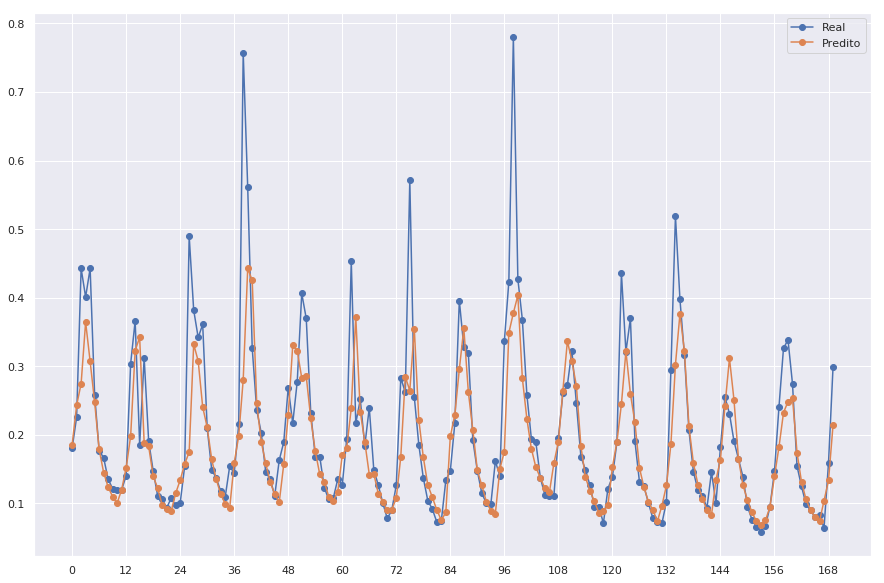

RMSE =  46.77034881080834, MSE =  2187.4655278846817, MAPE =  16.829266317349852 %, MAE =  24.867654045890358, R =  0.5905059733946818


In [8]:
def modelo_mlp(janela, quant_rios, ruido=0.05): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela*quant_rios,))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = Dense(12, activation='tanh')(entrada_ruidosa)
    X = GaussianDropout(0.003)(X)
    X = Dense(6, activation='tanh')(X)
    X = GaussianDropout(0.001)(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive/melhor_mlp.h5'): # or True:
    mlp = modelo_mlp(janela, 2)
    mlp.compile(optimizer='adam', loss='mape')
    parar_mlp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_mlp = ModelCheckpoint('modelos_naive/melhor_mlp.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_mlp = mlp.fit(x_treina, y_treina, epochs=10000, validation_data=(x_valida, y_valida), verbose=0, callbacks=[parar_mlp, salvar_mlp])
    salva_historico(historico_mlp.history, 'historicos_naive/mlp')

mostra_treinamento(carrega_historico('historicos_naive/mlp'))
mlp = load_model('modelos_naive/melhor_mlp.h5')
mostra_performance(mlp, x_valida, y_valida, fatores_normalizacao)

## Divisão do conjuntos de dados para redes recorrentes

Para o treinamento de redes recorrentes no Keras é necessário escrever um tensor de ordem 3

In [9]:
janela_reco = janela + adicional_reco
valida_reco = int((len(furnas) - teste - janela_reco) * fracao_valida)
treino_reco = len(furnas) - teste - valida_reco - janela_reco

x_treina_reco, y_treina_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco, treino_reco)
x_valida_reco, y_valida_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco+treino_reco, valida_reco)
x_teste_reco, y_teste_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco+treino_reco+valida_reco, teste)

assert(x_treina_reco[31, -1, -1] == y_treina_reco[30, -1])
print('Treino, ', treino_reco)
print('Validação, ', valida_reco)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela_reco)

Treino,  634
Validação,  158
Teste,  120
Total,  912


## Rede Recorrente Simples

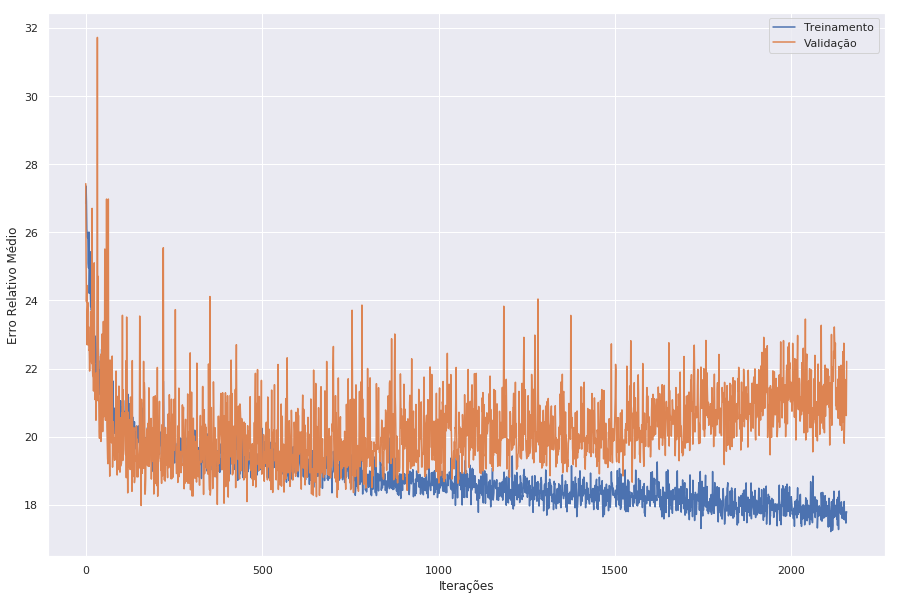

/usr/lib64/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Furnas


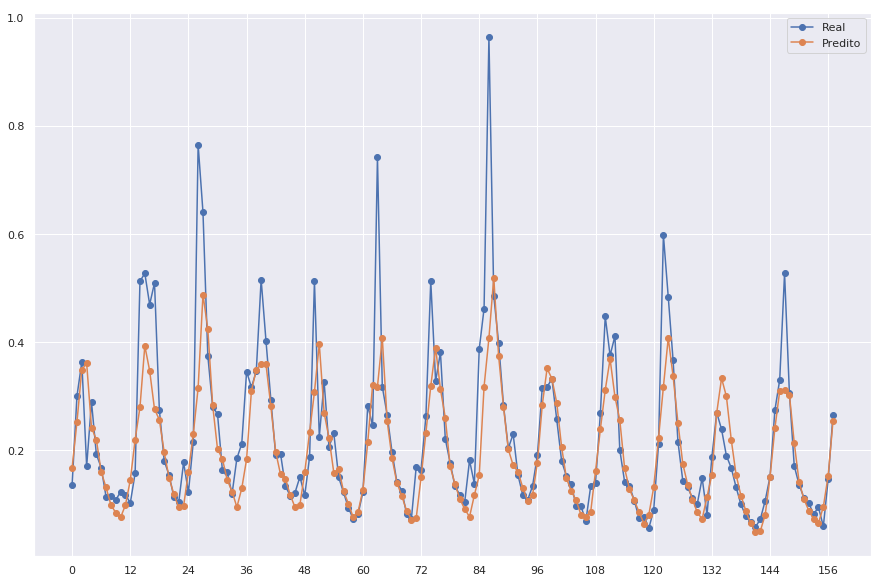

RMSE =  362.82188653083097, MSE =  131639.7213457912, MAPE =  19.548631319639924 %, MAE =  195.01918661252512, R =  0.6013571498110736
Camargos


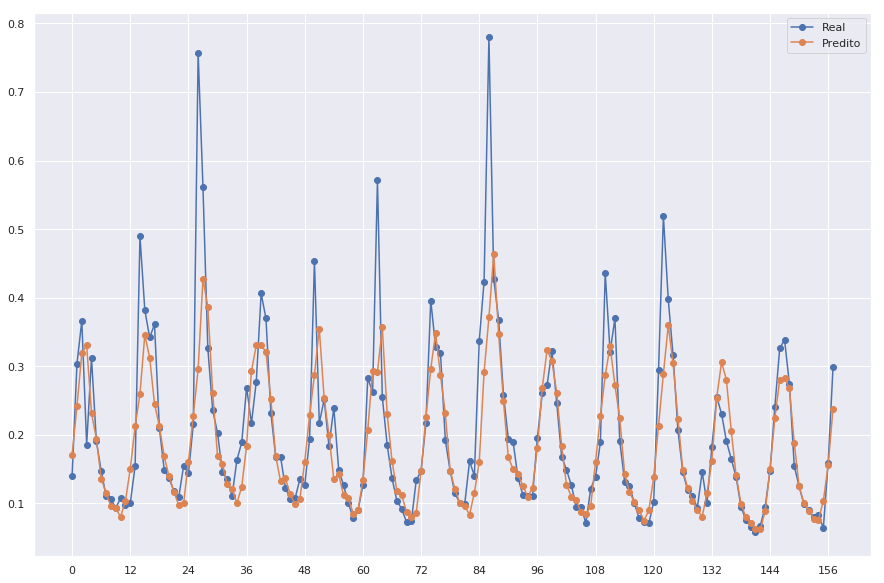

RMSE =  43.96643462212066, MSE =  1933.0473733812103, MAPE =  16.375897671162924 %, MAE =  23.4690310924868, R =  0.6393017151644744


<IPython.core.display.Javascript object>

In [10]:
def modelo_reco(janela, quant_rios, ruido=0.05): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela, quant_rios))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = Dense(12, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(entrada_ruidosa)
    X = GaussianDropout(0.004)(X)
    X = SimpleRNN(12)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='tanh')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive/melhor_reco.h5'): # or True:
    reco = modelo_reco(janela_reco, 2)
    reco.compile(optimizer='adam', loss='mape')
    parar_reco = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_reco = ModelCheckpoint('modelos_naive/melhor_reco.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_reco = reco.fit(x_treina_reco, y_treina_reco, epochs=10000, validation_data=(x_valida_reco, y_valida_reco), verbose=0, callbacks=[parar_reco, salvar_reco])
    salva_historico(historico_reco.history, 'historicos_naive/reco')

mostra_treinamento(carrega_historico('historicos_naive/reco'))
reco = load_model('modelos_naive/melhor_reco.h5')
mostra_performance(reco, x_valida_reco, y_valida_reco, fatores_normalizacao)

# LSTM

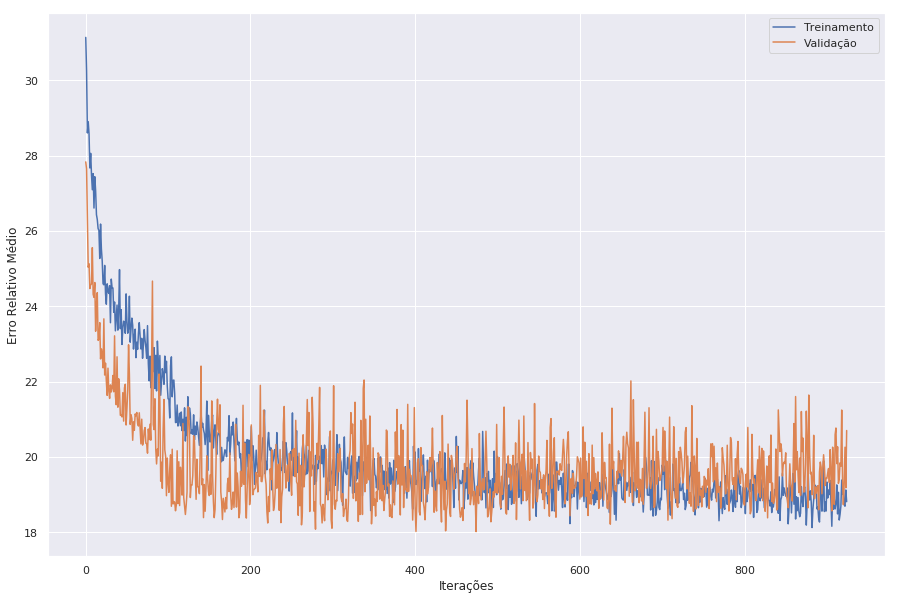

Furnas


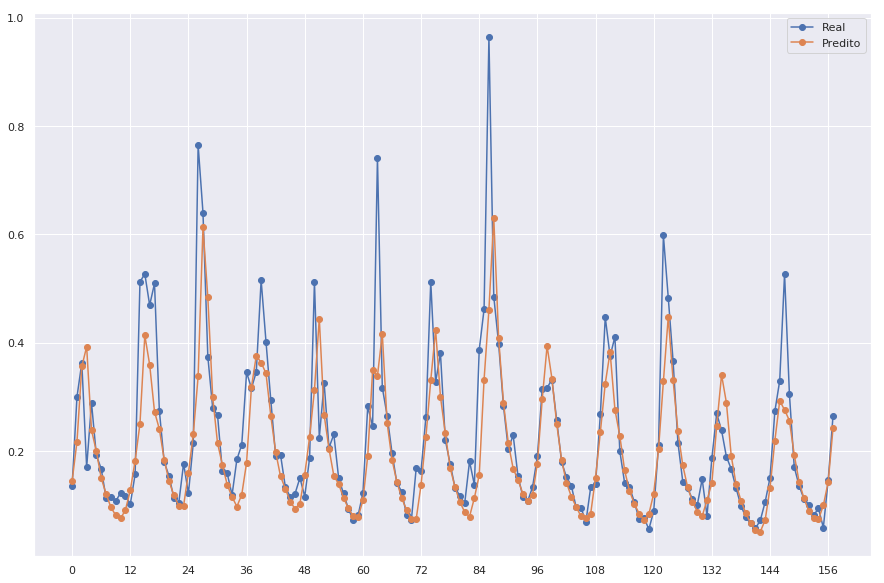

RMSE =  358.73075465967895, MSE =  128687.75433870275, MAPE =  19.32571670592529 %, MAE =  196.41649861930856, R =  0.6102965529740312
Camargos


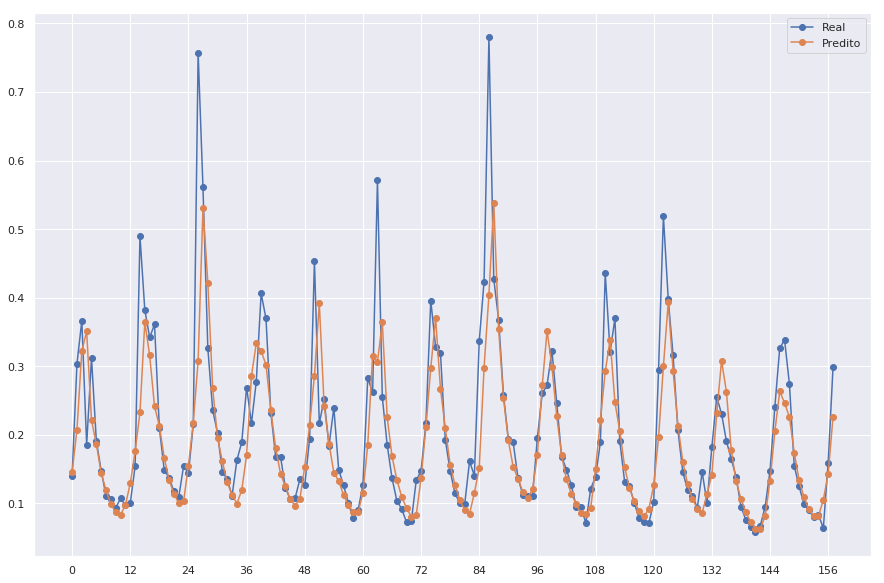

RMSE =  44.22929053613829, MSE =  1956.230141330132, MAPE =  16.70643307487448 %, MAE =  24.057853988454312, R =  0.6349759108660057


In [11]:
def modelo_lstm(janela, quant_rios, ruido=0.04): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela, quant_rios))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = LSTM(24)(entrada_ruidosa)
    X = Dropout(rate=0.2)(X)
    X = Dense(6, activation='tanh')(X)
    X = Dropout(rate=0.1)(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive/melhor_lstm.h5'): # or True:
    lstm = modelo_lstm(janela_reco, 2)
    lstm.compile(optimizer='adam', loss='mape')
    parar_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=450, min_delta=0, restore_best_weights=True)
    salvar_lstm = ModelCheckpoint('modelos_naive/melhor_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_lstm = lstm.fit(x_treina_reco, y_treina_reco, epochs=7500, validation_data=(x_valida_reco, y_valida_reco), verbose=0, callbacks=[parar_lstm, salvar_lstm])
    salva_historico(historico_lstm.history, 'historicos_naive/lstm')

mostra_treinamento(carrega_historico('historicos_naive/lstm'))
lstm = load_model('modelos_naive/melhor_lstm.h5')
mostra_performance(lstm, x_valida_reco, y_valida_reco, fatores_normalizacao)

## GRU

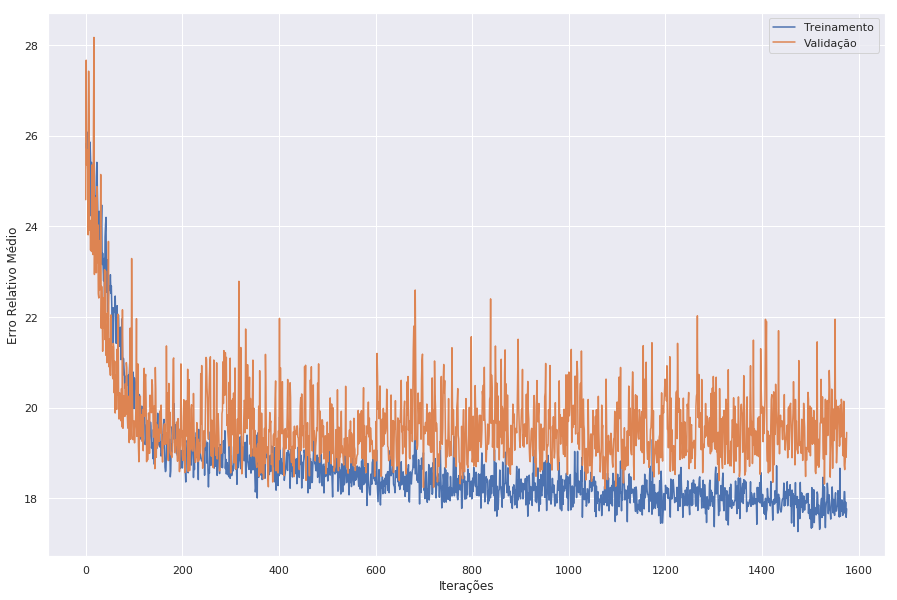

Furnas


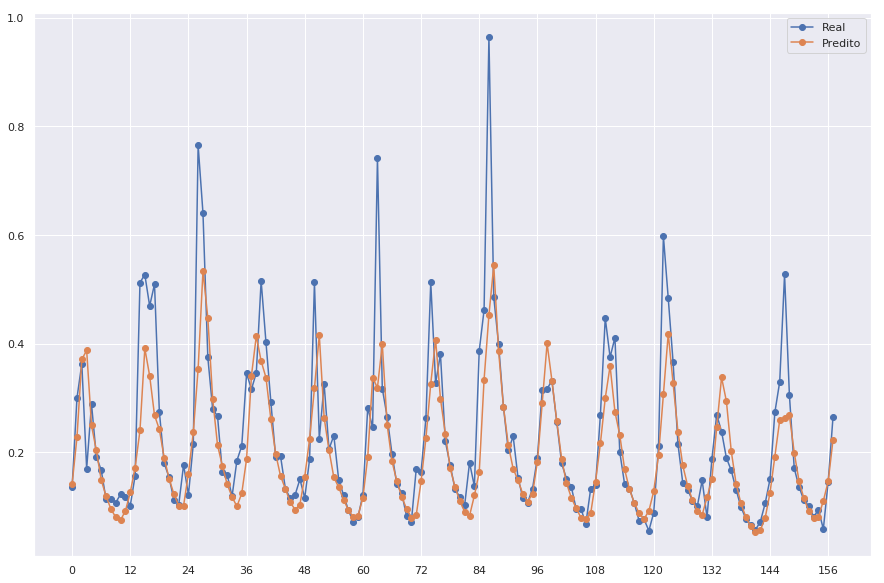

RMSE =  361.5714036755642, MSE =  130733.8799559178, MAPE =  19.388595167190275 %, MAE =  199.20499379939952, R =  0.6041002974703555
Camargos


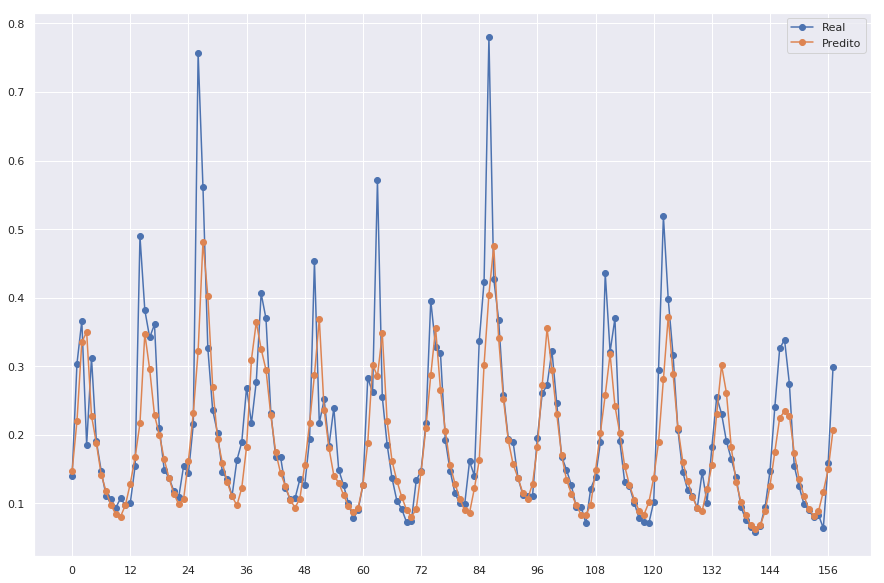

RMSE =  44.83955213101822, MSE =  2010.5854353103014, MAPE =  16.919244993095056 %, MAE =  24.53944768784921, R =  0.6248334479443216


In [12]:
def modelo_gru(janela, quant_rios, ruido=0.05): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela, quant_rios))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = Dense(12, activation='tanh', kernel_regularizer=regularizers.l2(0.02))(entrada_ruidosa)
    X = GaussianDropout(0.004)(X)
    X = GRU(9)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='tanh')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive/melhor_gru.h5'): # or True:
    gru = modelo_gru(janela_reco, 2)
    gru.compile(optimizer='adam', loss='mape')
    parar_gru = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_gru = ModelCheckpoint('modelos_naive/melhor_gru.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_gru = gru.fit(x_treina_reco, y_treina_reco, epochs=2000, validation_data=(x_valida_reco, y_valida_reco), verbose=0, callbacks=[parar_gru, salvar_gru])
    salva_historico(historico_gru.history, 'historicos_naive/gru')

mostra_treinamento(carrega_historico('historicos_naive/gru'))
gru = load_model('modelos_naive/melhor_gru.h5')
mostra_performance(gru, x_valida_reco, y_valida_reco, fatores_normalizacao)

## Teste dos modelos

Essas avaliações devem ser executados somente após a escolha definitiva dos modelos, para que os hiperparâmetros não se tornem enviesados ao conjunto de teste.

Único Neurônio
Furnas


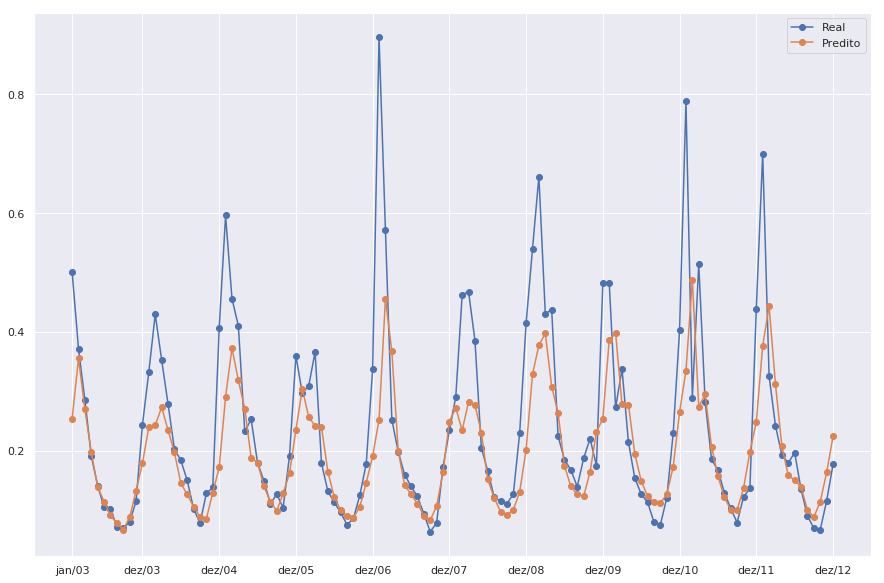

RMSE =  446.7642028749951, MSE =  199598.2529705298, MAPE =  22.514037972544802 %, MAE =  258.9214711620783, R =  0.46667433171136896
MAPE seco =  15.460699041111466 %
MAPE umido =  29.567376903978126 %
Camargos


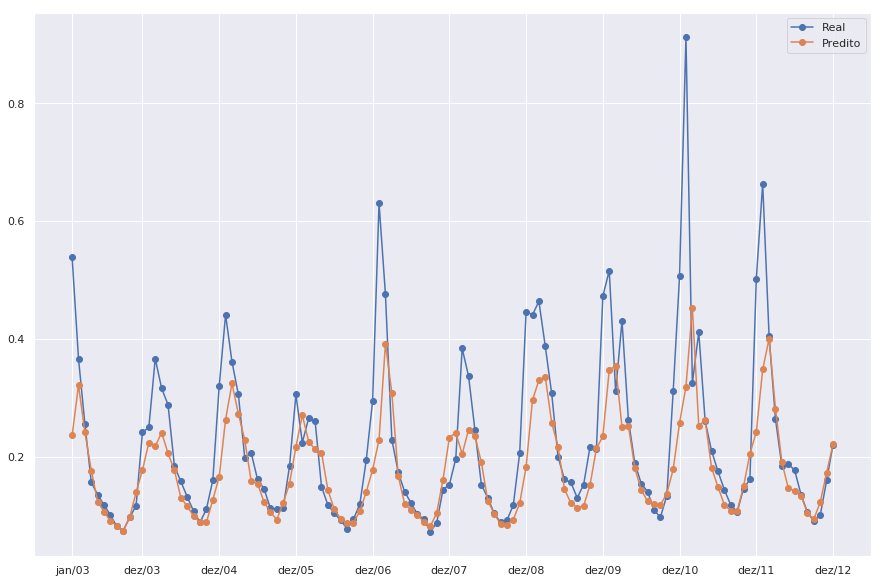

RMSE =  61.27063595513055, MSE =  3754.090830346137, MAPE =  18.55491180967133 %, MAE =  33.221845897038776, R =  0.4563675299547253
MAPE seco =  10.6446126099964 %
MAPE umido =  26.465211009346262 %



MLP
Furnas


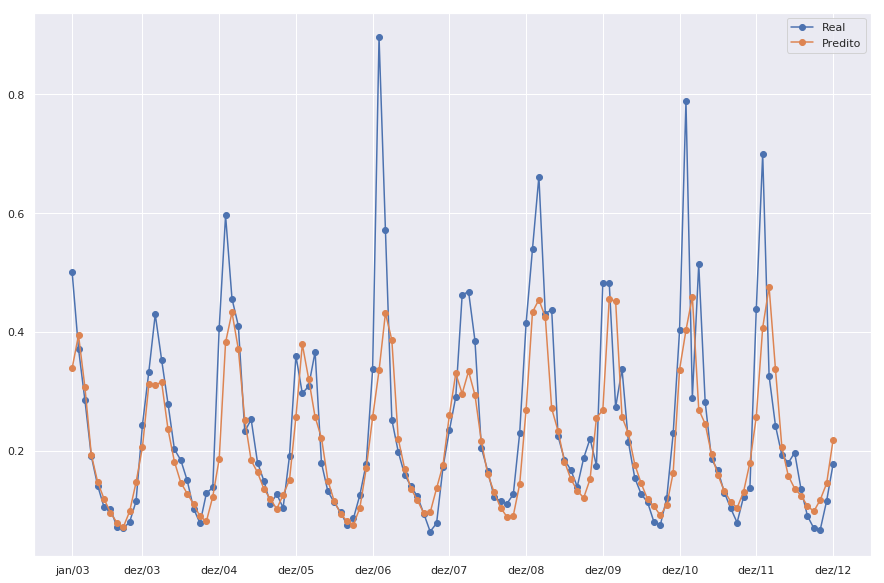

RMSE =  381.1207574202977, MSE =  145253.0317366214, MAPE =  20.68212625443903 %, MAE =  222.09592690598222, R =  0.6118845277001439
MAPE seco =  15.896580515961842 %
MAPE umido =  25.467671992916223 %
Camargos


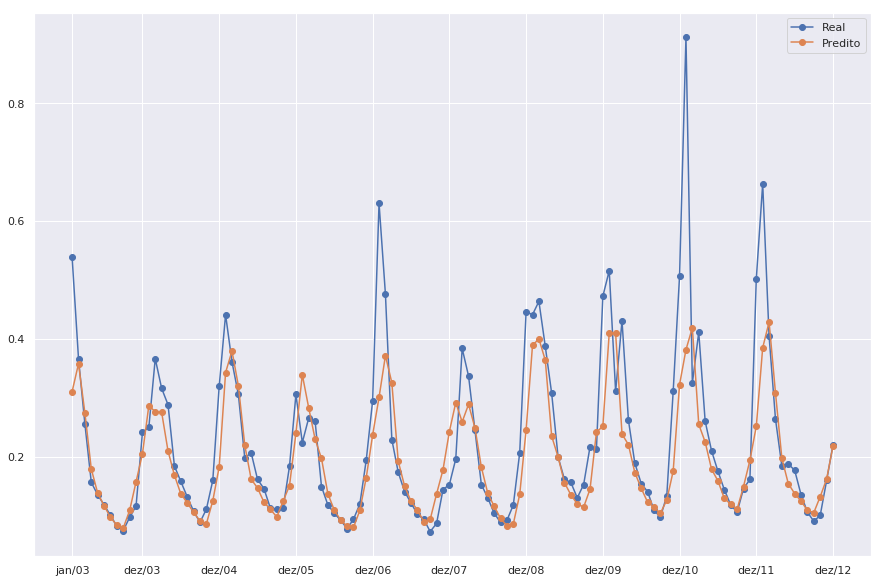

RMSE =  52.53737452598728, MSE =  2760.1757220838567, MAPE =  17.64494735364525 %, MAE =  29.23295751015345, R =  0.6002970590306429
MAPE seco =  11.018349071745309 %
MAPE umido =  24.271545635545184 %



Recorrente Simples
Furnas


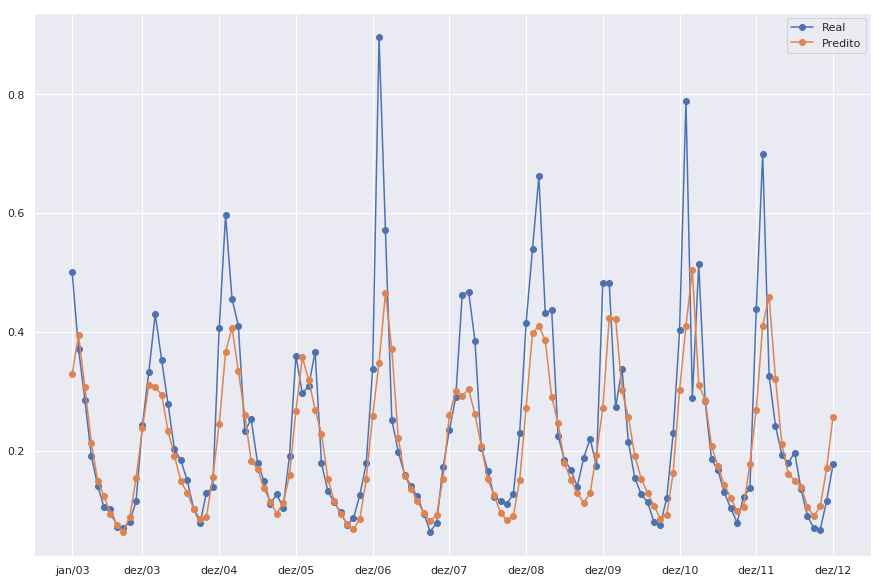

RMSE =  377.64041694535, MSE =  142612.2845106578, MAPE =  20.37441195667253 %, MAE =  223.7951764256383, R =  0.6189405928615775
MAPE seco =  14.8720457362491 %
MAPE umido =  25.876778177095964 %
Camargos


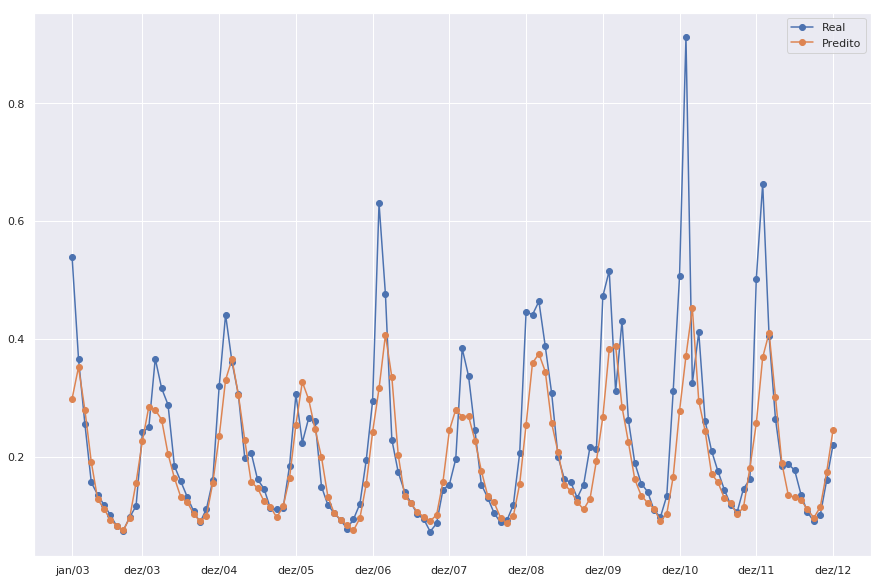

RMSE =  52.41114575280978, MSE =  2746.9281991222706, MAPE =  16.894610089843397 %, MAE =  28.76120544274648, R =  0.6022154419241449
MAPE seco =  10.63935284948104 %
MAPE umido =  23.149867330205744 %



LSTM
Furnas


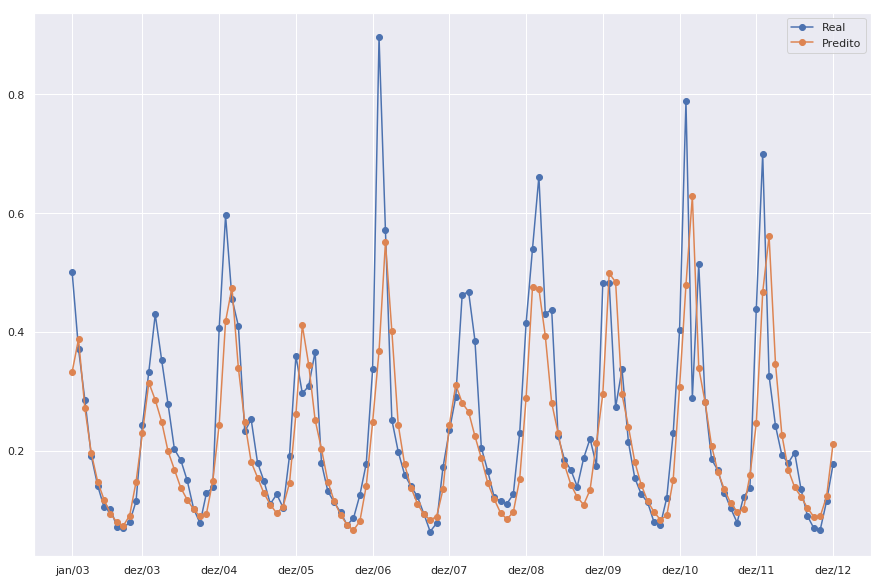

RMSE =  378.15572671455, MSE =  143001.7536470094, MAPE =  20.54901890754537 %, MAE =  224.48486379732688, R =  0.6178999330144536
MAPE seco =  14.530839255217204 %
MAPE umido =  26.567198559873546 %
Camargos


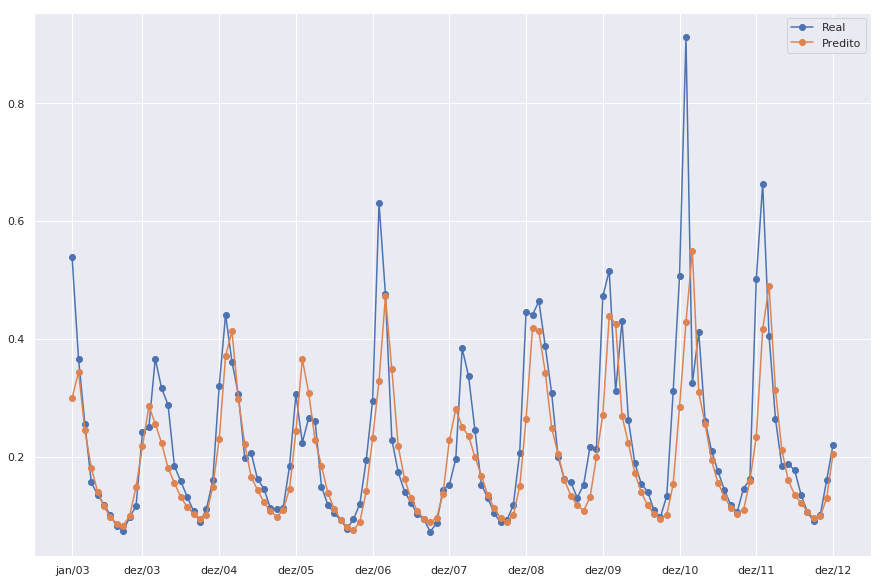

RMSE =  51.70613553940731, MSE =  2673.5244524195605, MAPE =  17.66857848476776 %, MAE =  29.53397701581319, R =  0.6128450888703517
MAPE seco =  10.414445463594081 %
MAPE umido =  24.922711505941443 %



GRU
Furnas


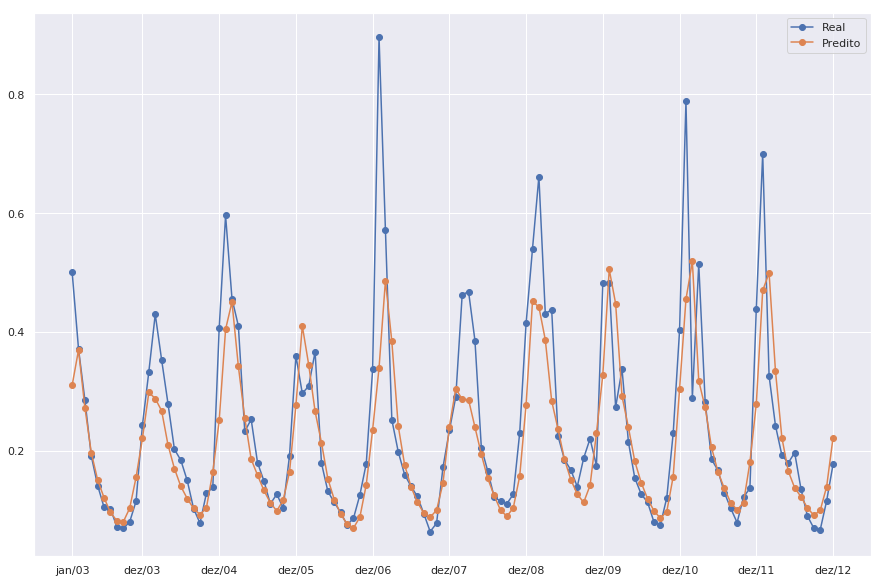

RMSE =  367.48435204734875, MSE =  135044.7489996598, MAPE =  20.431434031154907 %, MAE =  220.1932879167299, R =  0.6391610150027316
MAPE seco =  14.85407875642791 %
MAPE umido =  26.0087893058819 %
Camargos


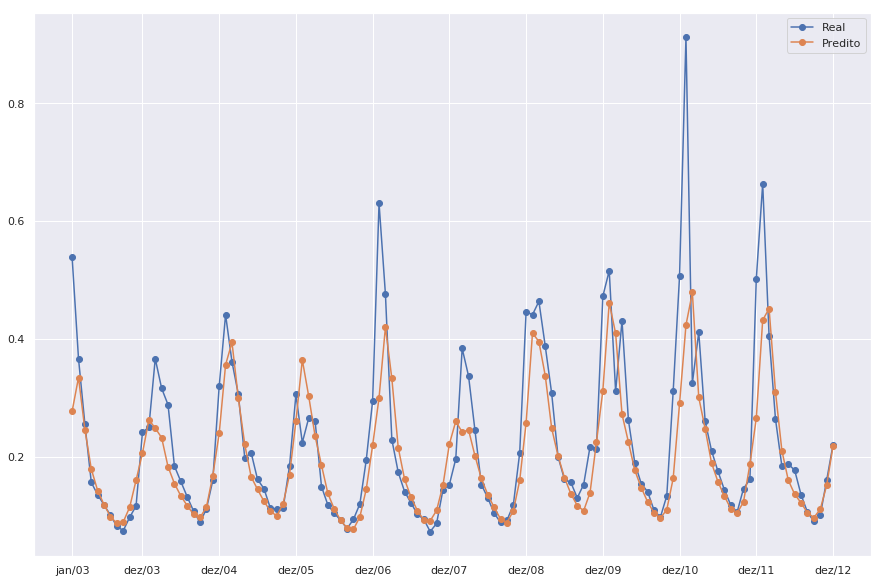

RMSE =  50.225037899038995, MSE =  2522.5544319599035, MAPE =  16.79901513708798 %, MAE =  28.218270834287008, R =  0.6347071611627533
MAPE seco =  10.181880256489587 %
MAPE umido =  23.416150017686363 %


In [13]:
executar_testes = True # Agora que todos os modelos foram definidos, execute a avaliação

if executar_testes:
    print('Único Neurônio')
    mostra_performance(uno, x_teste, y_teste, fatores_normalizacao, teste=True)
    print('\n\n\nMLP')
    mostra_performance(mlp, x_teste, y_teste, fatores_normalizacao, teste=True)
    print('\n\n\nRecorrente Simples')
    mostra_performance(reco, x_teste_reco, y_teste_reco, fatores_normalizacao, teste=True)
    print('\n\n\nLSTM')
    mostra_performance(lstm, x_teste_reco, y_teste_reco, fatores_normalizacao, teste=True)
    print('\n\n\nGRU')
    mostra_performance(gru , x_teste_reco, y_teste_reco, fatores_normalizacao, teste=True)